# Imports

In [132]:
import pandas as pd
import numpy as np

from statsmodels.tsa.stattools import adfuller

from sklearn.model_selection import TimeSeriesSplit

In [133]:
import numpy as np 
import pandas as pd

# visualizations
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
rcParams['figure.figsize'] = (12,5)
%matplotlib inline

# time series related 
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import mse,rmse
from statsmodels.tsa.statespace.varmax import VARMAX,VARMAXResults

# handle warnings
import warnings
warnings.filterwarnings(action='ignore',category=DeprecationWarning)
warnings.filterwarnings(action='ignore',category=FutureWarning)

# Load DataFrame

In [134]:
df = pd.read_csv('../../raw_data/df.csv')
df = df.drop(columns='Unnamed: 0')
df['Day'] = pd.to_datetime(df['Day'])
df.set_index('Day', inplace=True)
df = df.rename(columns={"fb_costs": "facebook", "google_costs": "google", "tt_costs": "tiktok"})
df = df.drop(columns = ['fb_impressions', 'fb_clicks', 'google_impressions', 'google_clicks', 'tt_impressions', 'tt_clicks'])

# Split Data

In [135]:
n_splits = 5  # Number of splits for cross-validation
tscv = TimeSeriesSplit(n_splits=n_splits)

for train_index, test_index in tscv.split(df):
    train_df = df.iloc[train_index]
    test_df = df.iloc[test_index]

y_train = train_df['total_sales']
X_train = train_df.drop(columns = ['total_sales', 'orders'])

y_test = test_df['total_sales']
X_test = test_df.drop(columns = ['total_sales', 'orders'])

In [136]:
df = train_df.drop(columns = ['orders'])

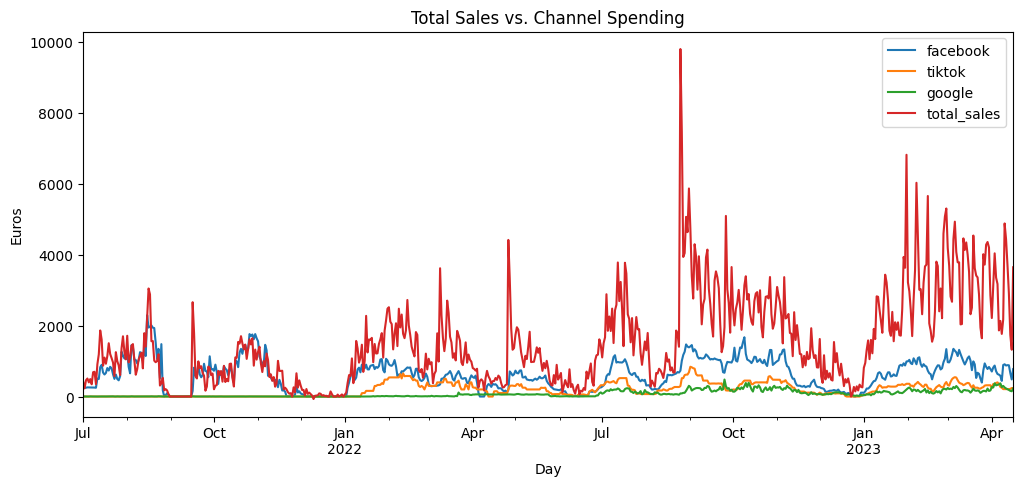

In [137]:
title = 'Total Sales vs. Channel Spending'
ylabel= 'Euros'
xlabel= ''

ax = df['facebook'].plot(figsize=(12,5),title=title,legend=True)
ax = df['tiktok'].plot(figsize=(12,5),title=title,legend=True)
ax = df['google'].plot(figsize=(12,5),title=title,legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
df['total_sales'].plot(legend=True);

In [138]:
def dickey_fuller(series,title='Your Dataset'):
    '''Hypothesis Test for stationarity '''
    print(f'Augmented Dickey Fuller Test for the dataset {title}')
    
    result = adfuller(series.dropna(),autolag='AIC')
    labels = ['ADF test statistics','p-value','#lags','#observations'] # use help(adfuller) to understand why these labels are chosen
    
    outcome = pd.Series(result[0:4],index=labels)
    
    for key,val in result[4].items():
        outcome[f'critical value ({key})'] = val
        
    print(outcome.to_string()) # this will not print the line 'dtype:float64'
    
    if result[1] <= 0.05:
        print('Strong evidence against the null hypothesis') # Ho is Data is not stationary, check help(adfuller)
        print('Reject the null hypothesis')
        print('Data is Stationary')
    else:
        print('Weak evidence against the Null hypothesis')
        print('Fail to reject the null hypothesis')
        print('Data has a unit root and is non stationary')

# Check for stationarity

* Stationarity is an assumption in VARIMA modeling

In [141]:
df_diff = df.diff().dropna()

In [15]:
dickey_fuller(df_diff['total_sales'],title='Total Sales 1st Order Diff')

Augmented Dickey Fuller Test for the dataset Total Sales 1st Order Diff
ADF test statistics    -7.756785e+00
p-value                 9.689929e-12
#lags                   1.400000e+01
#observations           6.390000e+02
critical value (1%)    -3.440625e+00
critical value (5%)    -2.866074e+00
critical value (10%)   -2.569184e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data is Stationary


In [16]:
dickey_fuller(df_diff['facebook'],title='Facebook 1st Order Diff')

Augmented Dickey Fuller Test for the dataset Facebook 1st Order Diff
ADF test statistics    -8.108487e+00
p-value                 1.244151e-12
#lags                   1.200000e+01
#observations           6.410000e+02
critical value (1%)    -3.440593e+00
critical value (5%)    -2.866060e+00
critical value (10%)   -2.569177e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data is Stationary


In [17]:
dickey_fuller(df_diff['google'],title='Google 1st Order Diff')

Augmented Dickey Fuller Test for the dataset Google 1st Order Diff
ADF test statistics    -7.934602e+00
p-value                 3.440330e-12
#lags                   1.900000e+01
#observations           6.340000e+02
critical value (1%)    -3.440706e+00
critical value (5%)    -2.866110e+00
critical value (10%)   -2.569203e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data is Stationary


In [18]:
dickey_fuller(df_diff['tiktok'],title='Tiktok 1st Order Diff')

Augmented Dickey Fuller Test for the dataset Tiktok 1st Order Diff
ADF test statistics     -24.700368
p-value                   0.000000
#lags                     0.000000
#observations           653.000000
critical value (1%)      -3.440404
critical value (5%)      -2.865976
critical value (10%)     -2.569132
Strong evidence against the null hypothesis
Reject the null hypothesis
Data is Stationary


In [142]:
len(df_diff)

654

# Check for seasonality

In [59]:
# try m = 7
# try m = 365
# check seasonality: resample by month => m = 12

In [64]:
ts = train_df['total_sales']

In [ ]:
# lower AIC = better

In [66]:
import pmdarima as pm

smodel = pm.auto_arima(ts, seasonal=True, m=7, 
                       start_p=20, max_p=30, max_d=1, start_q=8, max_q=15,
                       start_P=3, max_P=8, max_D=1, start_Q=8, max_Q=15, 
                       trace=True, error_action='ignore', suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(6,1,6)(3,0,8)[7] intercept   : AIC=10400.408, Time=70.79 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=10556.234, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=10497.322, Time=0.09 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=10471.380, Time=0.66 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=10554.262, Time=0.01 sec
 ARIMA(6,1,6)(2,0,8)[7] intercept   : AIC=10398.263, Time=66.68 sec
 ARIMA(6,1,6)(1,0,8)[7] intercept   : AIC=10396.563, Time=65.53 sec
 ARIMA(6,1,6)(0,0,8)[7] intercept   : AIC=10394.762, Time=62.36 sec


# Model Identification

* Determine order (p, q) of the autoregressive (AR) and moving average (MA) components for each feature

### ACF
  * The blue cone represents a confidence interval (the default is 95%)

  * Peak inside of cone ➔ not statistically significant

### PACF
  * The PACF plot provides insights into the direct correlation between a specific lagged data point and the current data point while removing the influence of intermediate lags

## Pre-Differencing

In [23]:
auto_arima(df['total_sales'],maxiter=100)

ARIMA(maxiter=100, order=(3, 1, 3), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [30]:
auto_arima(df['facebook'],maxiter=100)

ARIMA(maxiter=100, order=(1, 0, 1), scoring_args={}, suppress_warnings=True)

In [26]:
auto_arima(df['google'],maxiter=100)

ARIMA(maxiter=100, order=(0, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [27]:
auto_arima(df['tiktok'],maxiter=100)

ARIMA(maxiter=100, order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

## Post Differencing

In [24]:
auto_arima(df_diff['total_sales'],maxiter=100)

ARIMA(maxiter=100, order=(3, 0, 3), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [29]:
auto_arima(df_diff['facebook'],maxiter=100)

ARIMA(maxiter=100, order=(0, 0, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [21]:
auto_arima(df_diff['google'],maxiter=100)

ARIMA(maxiter=100, order=(0, 0, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [22]:
auto_arima(df_diff['tiktok'],maxiter=100)

ARIMA(maxiter=100, order=(0, 0, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [32]:
train_df = df_diff
test_df = test_df.diff().dropna()

In [47]:
train_df

,total_sales,facebook,google,tiktok
Day,,,,
2021-07-02,-184.90,-6.71,-0.33,0.00
2021-07-03,229.94,-1.71,-0.12,0.00
2021-07-04,48.47,9.46,-0.65,0.00
2021-07-05,-108.48,-0.58,0.31,0.00
2021-07-06,92.99,-1.07,3.10,0.00
...,...,...,...,...
2023-04-12,-725.65,9.76,-19.68,-0.49
2023-04-13,-804.49,-3.16,-22.05,-0.21
2023-04-14,-1178.17,-220.09,-25.78,7.56


In [33]:
len(train_df)

654

In [34]:
len(test_df)

129

# Model

In [143]:
model = VARMAX(df_diff, order=(0,1), trend='c') # c indicates a constant trend
results = model.fit(maxiter=1000, disp=False)
results.summary() # AIC	31826.851

/Users/valeriajimenez/.pyenv/versions/3.10.6/envs/MMM-project-lewagon/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/valeriajimenez/.pyenv/versions/3.10.6/envs/MMM-project-lewagon/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Dep. Variable:,"['total_sales', 'facebook', 'google', 'tiktok']",No. Observations:,654
Model:,VMA(1),Log Likelihood,-15883.425
,+ intercept,AIC,31826.851
Date:,"Tue, 05 Sep 2023",BIC,31961.344
Time:,17:30:41,HQIC,31879.003
Sample:,07-02-2021,,
,- 04-16-2023,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"56.89, 0.15, 0.85, 0.03",Jarque-Bera (JB):,"28559.95, 3836.48, 6059.37, 1205.51"
Prob(Q):,"0.00, 0.70, 0.36, 0.87",Prob(JB):,"0.00, 0.00, 0.00, 0.00"
Heteroskedasticity (H):,"4.38, 0.31, 100.50, 3.37",Skew:,"3.52, 0.26, 1.42, -0.01"


In [144]:
model = VARMAX(train_df, order=(0,1), trend='ct') # c indicates a constant trend
results = model.fit(maxiter=1000, disp=False)
results.summary() # AIC	39808.915

/Users/valeriajimenez/.pyenv/versions/3.10.6/envs/MMM-project-lewagon/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/valeriajimenez/.pyenv/versions/3.10.6/envs/MMM-project-lewagon/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Dep. Variable:,"['orders', 'total_sales', 'facebook', 'google', 'tiktok']",No. Observations:,655
Model:,VMA(1),Log Likelihood,-19854.457
,+ intercept,AIC,39808.915
Date:,"Tue, 05 Sep 2023",BIC,40033.146
Time:,17:32:03,HQIC,39895.858
Sample:,07-01-2021,,
,- 04-16-2023,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"150.86, 53.97, 102.39, 0.14, 170.26",Jarque-Bera (JB):,"6393.80, 112.54, 810.82, 902.62, 176.43"
Prob(Q):,"0.00, 0.00, 0.00, 0.71, 0.00",Prob(JB):,"0.00, 0.00, 0.00, 0.00, 0.00"
Heteroskedasticity (H):,"2.21, 2.22, 0.34, 7.33, 1.85",Skew:,"2.08, 0.20, 1.26, 0.91, 1.03"


In [54]:
model = VARMAX(train_df, order=(0,2), trend='c') # c indicates a constant trend
results = model.fit(maxiter=1000, disp=False)
results.summary() # AIC	31826.851

/Users/valeriajimenez/.pyenv/versions/3.10.6/envs/MMM-project-lewagon/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/valeriajimenez/.pyenv/versions/3.10.6/envs/MMM-project-lewagon/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Dep. Variable:,"['total_sales', 'facebook', 'google', 'tiktok']",No. Observations:,654
Model:,VMA(1),Log Likelihood,-15883.425
,+ intercept,AIC,31826.851
Date:,"Tue, 05 Sep 2023",BIC,31961.344
Time:,16:29:04,HQIC,31879.003
Sample:,07-02-2021,,
,- 04-16-2023,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"56.89, 0.15, 0.85, 0.03",Jarque-Bera (JB):,"28559.95, 3836.48, 6059.37, 1205.51"
Prob(Q):,"0.00, 0.70, 0.36, 0.87",Prob(JB):,"0.00, 0.00, 0.00, 0.00"
Heteroskedasticity (H):,"4.38, 0.31, 100.50, 3.37",Skew:,"3.52, 0.26, 1.42, -0.01"


In [56]:
model = VARMAX(train_df, order=(0,3), trend='c') # c indicates a constant trend
results = model.fit(maxiter=1000, disp=False)
results.summary() # AIC	31751.605

/Users/valeriajimenez/.pyenv/versions/3.10.6/envs/MMM-project-lewagon/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/valeriajimenez/.pyenv/versions/3.10.6/envs/MMM-project-lewagon/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Dep. Variable:,"['total_sales', 'facebook', 'google', 'tiktok']",No. Observations:,654
Model:,VMA(3),Log Likelihood,-15813.803
,+ intercept,AIC,31751.605
Date:,"Tue, 05 Sep 2023",BIC,32029.558
Time:,16:32:53,HQIC,31859.386
Sample:,07-02-2021,,
,- 04-16-2023,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"0.00, 0.00, 0.09, 0.12",Jarque-Bera (JB):,"44503.62, 4840.84, 6470.88, 1064.84"
Prob(Q):,"0.98, 0.96, 0.76, 0.73",Prob(JB):,"0.00, 0.00, 0.00, 0.00"
Heteroskedasticity (H):,"3.86, 0.27, 51.39, 3.12",Skew:,"4.04, 0.33, 1.56, -0.01"


In [57]:
model = VARMAX(train_df, order=(1,1), trend='c') # c indicates a constant trend
results = model.fit(maxiter=1000, disp=False)
results.summary() # AIC	31740.429

/Users/valeriajimenez/.pyenv/versions/3.10.6/envs/MMM-project-lewagon/lib/python3.10/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/Users/valeriajimenez/.pyenv/versions/3.10.6/envs/MMM-project-lewagon/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/valeriajimenez/.pyenv/versions/3.10.6/envs/MMM-project-lewagon/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Dep. Variable:,"['total_sales', 'facebook', 'google', 'tiktok']",No. Observations:,654
Model:,"VARMA(1,1)",Log Likelihood,-15824.215
,+ intercept,AIC,31740.429
Date:,"Tue, 05 Sep 2023",BIC,31946.652
Time:,16:33:44,HQIC,31820.396
Sample:,07-02-2021,,
,- 04-16-2023,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"1.44, 0.09, 2.50, 0.10",Jarque-Bera (JB):,"37597.03, 4305.34, 8186.40, 1141.85"
Prob(Q):,"0.23, 0.77, 0.11, 0.75",Prob(JB):,"0.00, 0.00, 0.00, 0.00"
Heteroskedasticity (H):,"4.25, 0.29, 41.43, 3.16",Skew:,"3.84, 0.35, 1.83, 0.11"


In [58]:
model = VARMAX(train_df, order=(1,2), trend='c') # c indicates a constant trend
results = model.fit(maxiter=1000, disp=False)
results.summary() # AIC	31751.623

/Users/valeriajimenez/.pyenv/versions/3.10.6/envs/MMM-project-lewagon/lib/python3.10/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/Users/valeriajimenez/.pyenv/versions/3.10.6/envs/MMM-project-lewagon/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/valeriajimenez/.pyenv/versions/3.10.6/envs/MMM-project-lewagon/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Dep. Variable:,"['total_sales', 'facebook', 'google', 'tiktok']",No. Observations:,654
Model:,"VARMA(1,2)",Log Likelihood,-15813.811
,+ intercept,AIC,31751.623
Date:,"Tue, 05 Sep 2023",BIC,32029.575
Time:,16:35:04,HQIC,31859.403
Sample:,07-02-2021,,
,- 04-16-2023,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"0.10, 0.05, 0.12, 0.20",Jarque-Bera (JB):,"42221.92, 4371.16, 6246.86, 1031.86"
Prob(Q):,"0.75, 0.83, 0.73, 0.66",Prob(JB):,"0.00, 0.00, 0.00, 0.00"
Heteroskedasticity (H):,"3.89, 0.28, 59.59, 3.04",Skew:,"3.98, 0.35, 1.51, 0.01"


In [59]:
model = VARMAX(train_df, order=(1,3), trend='c') # c indicates a constant trend
results = model.fit(maxiter=1000, disp=False)
results.summary() # AIC	31751.618

/Users/valeriajimenez/.pyenv/versions/3.10.6/envs/MMM-project-lewagon/lib/python3.10/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/Users/valeriajimenez/.pyenv/versions/3.10.6/envs/MMM-project-lewagon/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/valeriajimenez/.pyenv/versions/3.10.6/envs/MMM-project-lewagon/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Dep. Variable:,"['total_sales', 'facebook', 'google', 'tiktok']",No. Observations:,654
Model:,"VARMA(1,3)",Log Likelihood,-15797.809
,+ intercept,AIC,31751.618
Date:,"Tue, 05 Sep 2023",BIC,32101.300
Time:,16:36:21,HQIC,31887.213
Sample:,07-02-2021,,
,- 04-16-2023,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"0.30, 0.11, 0.02, 0.12",Jarque-Bera (JB):,"42897.73, 4767.41, 6371.03, 1026.95"
Prob(Q):,"0.58, 0.74, 0.89, 0.73",Prob(JB):,"0.00, 0.00, 0.00, 0.00"
Heteroskedasticity (H):,"3.97, 0.28, 39.62, 3.15",Skew:,"3.99, 0.38, 1.60, 0.05"


In [60]:
model = VARMAX(train_df, order=(2,1), trend='c') # c indicates a constant trend
results = model.fit(maxiter=1000, disp=False)
results.summary() # AIC	31727.305

/Users/valeriajimenez/.pyenv/versions/3.10.6/envs/MMM-project-lewagon/lib/python3.10/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/Users/valeriajimenez/.pyenv/versions/3.10.6/envs/MMM-project-lewagon/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/valeriajimenez/.pyenv/versions/3.10.6/envs/MMM-project-lewagon/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Dep. Variable:,"['total_sales', 'facebook', 'google', 'tiktok']",No. Observations:,654
Model:,"VARMA(2,1)",Log Likelihood,-15801.653
,+ intercept,AIC,31727.305
Date:,"Tue, 05 Sep 2023",BIC,32005.258
Time:,16:37:28,HQIC,31835.086
Sample:,07-02-2021,,
,- 04-16-2023,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"0.01, 0.62, 0.08, 0.02",Jarque-Bera (JB):,"46713.50, 4256.25, 6442.81, 1089.59"
Prob(Q):,"0.93, 0.43, 0.77, 0.88",Prob(JB):,"0.00, 0.00, 0.00, 0.00"
Heteroskedasticity (H):,"3.84, 0.28, 35.85, 3.15",Skew:,"4.04, 0.35, 1.64, 0.04"


In [61]:
model = VARMAX(train_df, order=(2,2), trend='c') # c indicates a constant trend
results = model.fit(maxiter=1000, disp=False)
results.summary() # AIC	31758.489

/Users/valeriajimenez/.pyenv/versions/3.10.6/envs/MMM-project-lewagon/lib/python3.10/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/Users/valeriajimenez/.pyenv/versions/3.10.6/envs/MMM-project-lewagon/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/valeriajimenez/.pyenv/versions/3.10.6/envs/MMM-project-lewagon/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Dep. Variable:,"['total_sales', 'facebook', 'google', 'tiktok']",No. Observations:,654
Model:,"VARMA(2,2)",Log Likelihood,-15801.245
,+ intercept,AIC,31758.489
Date:,"Tue, 05 Sep 2023",BIC,32108.172
Time:,16:39:02,HQIC,31894.085
Sample:,07-02-2021,,
,- 04-16-2023,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"0.00, 0.16, 0.17, 0.00",Jarque-Bera (JB):,"42159.38, 4634.72, 6734.30, 1048.45"
Prob(Q):,"0.98, 0.69, 0.68, 0.98",Prob(JB):,"0.00, 0.00, 0.00, 0.00"
Heteroskedasticity (H):,"3.84, 0.27, 35.69, 3.19",Skew:,"3.91, 0.43, 1.70, 0.03"


In [62]:
model = VARMAX(train_df, order=(2,3), trend='c') # c indicates a constant trend
results = model.fit(maxiter=1000, disp=False)
results.summary() # AIC	31744.381

/Users/valeriajimenez/.pyenv/versions/3.10.6/envs/MMM-project-lewagon/lib/python3.10/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/Users/valeriajimenez/.pyenv/versions/3.10.6/envs/MMM-project-lewagon/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/valeriajimenez/.pyenv/versions/3.10.6/envs/MMM-project-lewagon/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Dep. Variable:,"['total_sales', 'facebook', 'google', 'tiktok']",No. Observations:,654
Model:,"VARMA(2,3)",Log Likelihood,-15778.191
,+ intercept,AIC,31744.381
Date:,"Tue, 05 Sep 2023",BIC,32165.793
Time:,16:41:09,HQIC,31907.791
Sample:,07-02-2021,,
,- 04-16-2023,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"0.60, 0.00, 0.20, 0.32",Jarque-Bera (JB):,"44951.39, 4554.38, 5789.72, 1019.83"
Prob(Q):,"0.44, 0.99, 0.65, 0.57",Prob(JB):,"0.00, 0.00, 0.00, 0.00"
Heteroskedasticity (H):,"3.71, 0.27, 34.31, 3.12",Skew:,"4.05, 0.36, 1.56, 0.04"


In [63]:
model = VARMAX(train_df, order=(3,1), trend='c') # c indicates a constant trend
results = model.fit(maxiter=1000, disp=False)
results.summary() # AIC	31715.084

/Users/valeriajimenez/.pyenv/versions/3.10.6/envs/MMM-project-lewagon/lib/python3.10/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/Users/valeriajimenez/.pyenv/versions/3.10.6/envs/MMM-project-lewagon/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/valeriajimenez/.pyenv/versions/3.10.6/envs/MMM-project-lewagon/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Dep. Variable:,"['total_sales', 'facebook', 'google', 'tiktok']",No. Observations:,654
Model:,"VARMA(3,1)",Log Likelihood,-15779.542
,+ intercept,AIC,31715.084
Date:,"Tue, 05 Sep 2023",BIC,32064.767
Time:,16:42:51,HQIC,31850.679
Sample:,07-02-2021,,
,- 04-16-2023,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"0.27, 0.03, 0.14, 0.00",Jarque-Bera (JB):,"52306.36, 4815.70, 5548.75, 996.64"
Prob(Q):,"0.60, 0.85, 0.70, 0.95",Prob(JB):,"0.00, 0.00, 0.00, 0.00"
Heteroskedasticity (H):,"3.85, 0.29, 43.12, 3.00",Skew:,"4.13, 0.33, 1.45, 0.09"


In [64]:
model = VARMAX(train_df, order=(3,2), trend='c') # c indicates a constant trend
results = model.fit(maxiter=1000, disp=False)
results.summary() # AIC	31756.056

/Users/valeriajimenez/.pyenv/versions/3.10.6/envs/MMM-project-lewagon/lib/python3.10/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/Users/valeriajimenez/.pyenv/versions/3.10.6/envs/MMM-project-lewagon/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/valeriajimenez/.pyenv/versions/3.10.6/envs/MMM-project-lewagon/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Dep. Variable:,"['total_sales', 'facebook', 'google', 'tiktok']",No. Observations:,654
Model:,"VARMA(3,2)",Log Likelihood,-15784.028
,+ intercept,AIC,31756.056
Date:,"Tue, 05 Sep 2023",BIC,32177.469
Time:,16:44:51,HQIC,31919.466
Sample:,07-02-2021,,
,- 04-16-2023,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"0.27, 0.11, 0.08, 0.06",Jarque-Bera (JB):,"50151.66, 4392.66, 6496.01, 979.97"
Prob(Q):,"0.61, 0.74, 0.78, 0.80",Prob(JB):,"0.00, 0.00, 0.00, 0.00"
Heteroskedasticity (H):,"3.85, 0.29, 37.26, 3.09",Skew:,"4.09, 0.41, 1.61, 0.01"


In [65]:
model = VARMAX(train_df, order=(3,3), trend='c') # c indicates a constant trend
results = model.fit(maxiter=1000, disp=False)
results.summary() # AIC	31756.916

/Users/valeriajimenez/.pyenv/versions/3.10.6/envs/MMM-project-lewagon/lib/python3.10/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/Users/valeriajimenez/.pyenv/versions/3.10.6/envs/MMM-project-lewagon/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/valeriajimenez/.pyenv/versions/3.10.6/envs/MMM-project-lewagon/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Dep. Variable:,"['total_sales', 'facebook', 'google', 'tiktok']",No. Observations:,654
Model:,"VARMA(3,3)",Log Likelihood,-15768.458
,+ intercept,AIC,31756.916
Date:,"Tue, 05 Sep 2023",BIC,32250.058
Time:,16:47:19,HQIC,31948.140
Sample:,07-02-2021,,
,- 04-16-2023,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"0.22, 0.00, 0.06, 0.00",Jarque-Bera (JB):,"56312.07, 4552.27, 5585.25, 967.71"
Prob(Q):,"0.64, 0.99, 0.81, 0.99",Prob(JB):,"0.00, 0.00, 0.00, 0.00"
Heteroskedasticity (H):,"3.87, 0.28, 38.15, 3.08",Skew:,"4.29, 0.33, 1.44, 0.01"


# Forecast

In [93]:
df_forecast = results.forecast(129)
original_forecast_df = pd.concat([train_df, df_forecast], axis = 0)
original_forecast_df

,total_sales,facebook,google,tiktok
2021-07-02,-184.900000,-6.710000,-0.330000,0.000000
2021-07-03,229.940000,-1.710000,-0.120000,0.000000
2021-07-04,48.470000,9.460000,-0.650000,0.000000
2021-07-05,-108.480000,-0.580000,0.310000,0.000000
2021-07-06,92.990000,-1.070000,3.100000,0.000000
...,...,...,...,...
2023-08-19,5.203898,0.854065,0.384564,0.952325
2023-08-20,5.203898,0.854065,0.384564,0.952325
2023-08-21,5.203898,0.854065,0.384564,0.952325
2023-08-22,5.203898,0.854065,0.384564,0.952325


In [107]:

# Reverse the first-order differencing
original_forecast_df_all = original_forecast_df.cumsum()

targets = ['total_sales', 'facebook', 'google', 'tiktok']


for target in targets:
    original_forecast_df[target] = original_forecast_df[target].cumsum()
original_forecast_df
original_forecast_df = original_forecast_df.rename(columns={"total_sales": "sales_forecast", "facebook": "facebook_forecast", "google": "google_forecast", "tiktok": "tiktok_forecast"})

In [113]:
len(original_forecast_df)

783

In [119]:
df = pd.read_csv('../../raw_data/df.csv')
df = df.drop(columns='Unnamed: 0')
df['Day'] = pd.to_datetime(df['Day'])
df.set_index('Day', inplace=True)
df = df.rename(columns={"fb_costs": "facebook", "google_costs": "google", "tt_costs": "tiktok"})
df = df.drop(columns = ['fb_impressions', 'fb_clicks', 'google_impressions', 'google_clicks', 'tt_impressions', 'tt_clicks', 'orders'])
len(df)

785

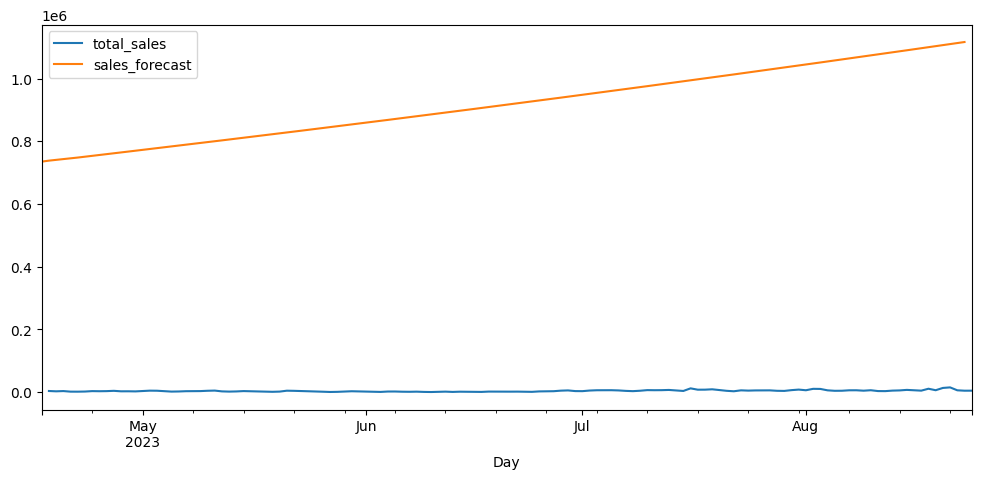

In [124]:
df['total_sales'][-129:].plot(figsize=(12,5),legend=True).autoscale(axis='x',tight=True)
original_forecast_df['sales_forecast'][-129:].plot(legend=True);

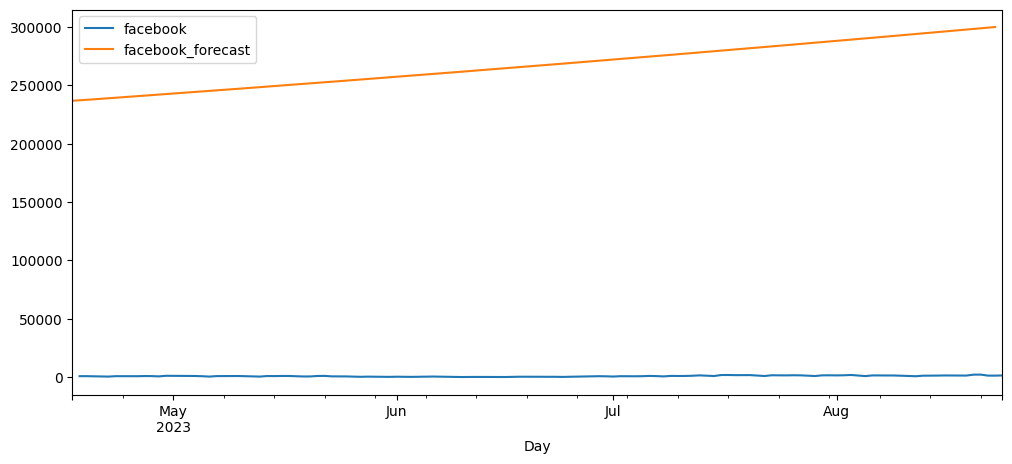

In [125]:
df['facebook'][-129:].plot(figsize=(12,5),legend=True).autoscale(axis='x',tight=True)
original_forecast_df['facebook_forecast'][-129:].plot(legend=True);

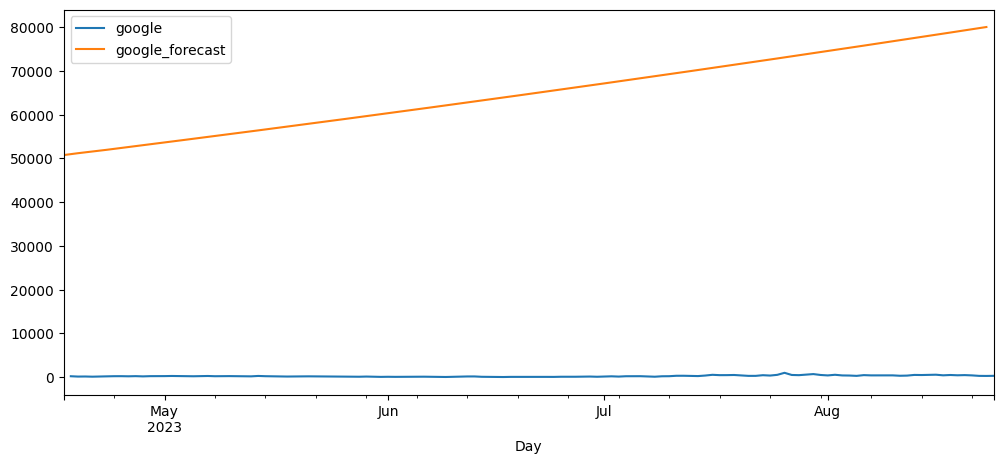

In [126]:
df['google'][-129:].plot(figsize=(12,5),legend=True).autoscale(axis='x',tight=True)
original_forecast_df['google_forecast'][-129:].plot(legend=True);

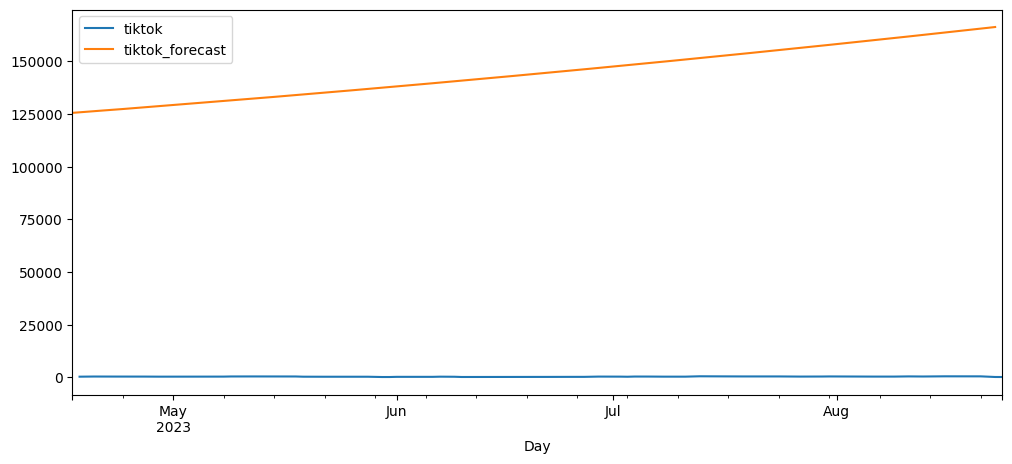

In [129]:
df['tiktok'][-129:].plot(figsize=(12,5),legend=True).autoscale(axis='x',tight=True)
original_forecast_df['tiktok_forecast'][-129:].plot(legend=True);

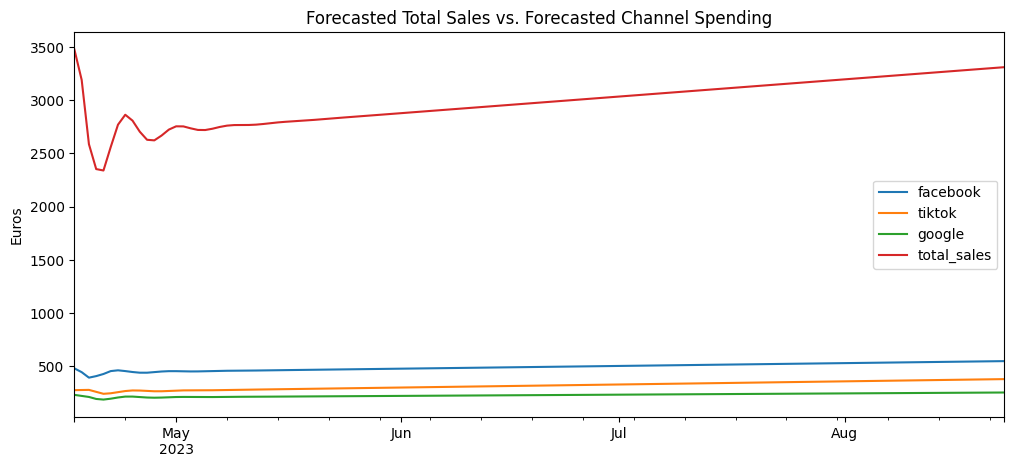

In [96]:
title = 'Forecasted Total Sales vs. Forecasted Channel Spending'
ylabel= 'Euros'
xlabel= ''

ax = original_forecast_df['facebook'][-129:].plot(figsize=(12,5),title=title,legend=True)
ax = original_forecast_df['tiktok'][-129:].plot(figsize=(12,5),title=title,legend=True)
ax = original_forecast_df['google'][-129:].plot(figsize=(12,5),title=title,legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
original_forecast_df['total_sales'][-129:].plot(legend=True);

# Model Evaluation

In [99]:
RMSE1 = rmse(train_df['total_sales'][-129:], original_forecast_df['total_sales'][-129:])
f'Money VAR(5) RMSE: {RMSE1:.3f}'

'Money VAR(5) RMSE: 3133.909'

In [100]:
RMSE1 = rmse(train_df['facebook'][-129:], original_forecast_df['facebook'][-129:])
f'Money VAR(5) RMSE: {RMSE1:.3f}'

'Money VAR(5) RMSE: 503.889'

In [101]:
RMSE1 = rmse(train_df['google'][-129:], original_forecast_df['google'][-129:])
f'Money VAR(5) RMSE: {RMSE1:.3f}'

'Money VAR(5) RMSE: 231.230'

In [102]:
RMSE1 = rmse(train_df['tiktok'][-129:], original_forecast_df['tiktok'][-129:])
f'Money VAR(5) RMSE: {RMSE1:.3f}'

'Money VAR(5) RMSE: 321.482'

# ACF, PACF

## Total Sales

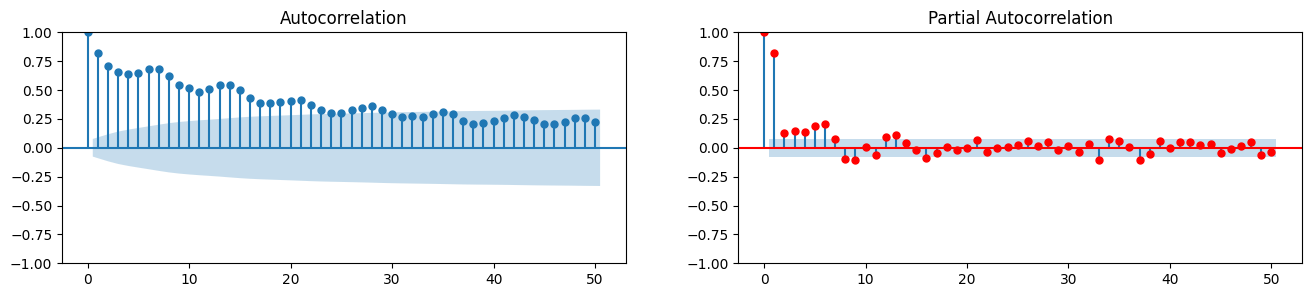

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(16,3))

plot_acf(train_df.total_sales, lags=50, ax=axes[0]); #q
plot_pacf(train_df.total_sales, lags=50, ax=axes[1], color='r'); #p

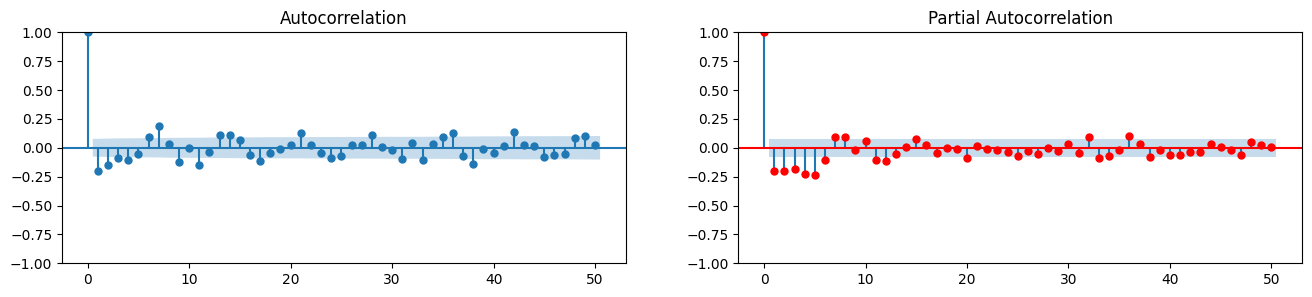

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(16,3))

plot_acf(train_df.total_sales.diff().dropna(), lags=50, ax=axes[0]); #q
plot_pacf(train_df.total_sales.diff().dropna(), lags=50, ax=axes[1], color='r'); #p

## Facebook

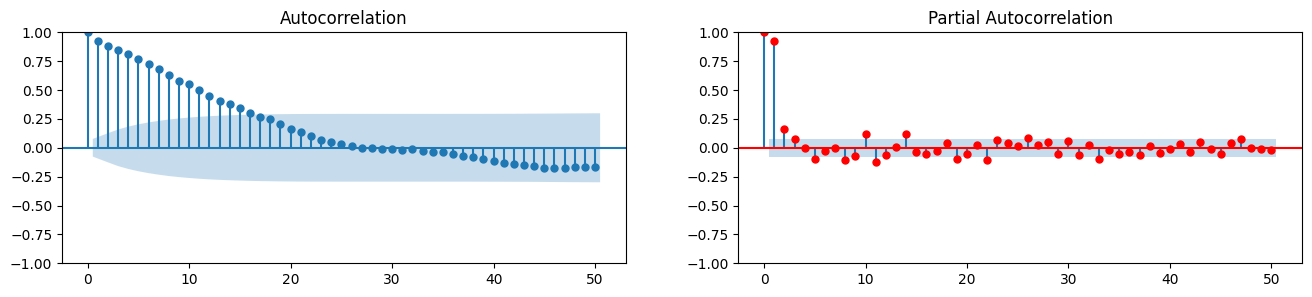

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(16,3))

plot_acf(train_df.facebook, lags=50, ax=axes[0]);
plot_pacf(train_df.facebook, lags=50, ax=axes[1], color='r');

## Google

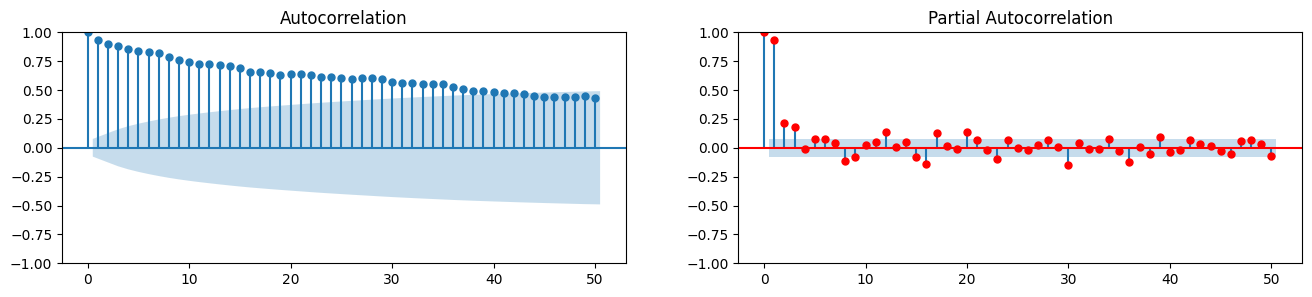

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(16,3))

plot_acf(train_df.google, lags=50, ax=axes[0]);
plot_pacf(train_df.google, lags=50, ax=axes[1], color='r');

## Tiktok

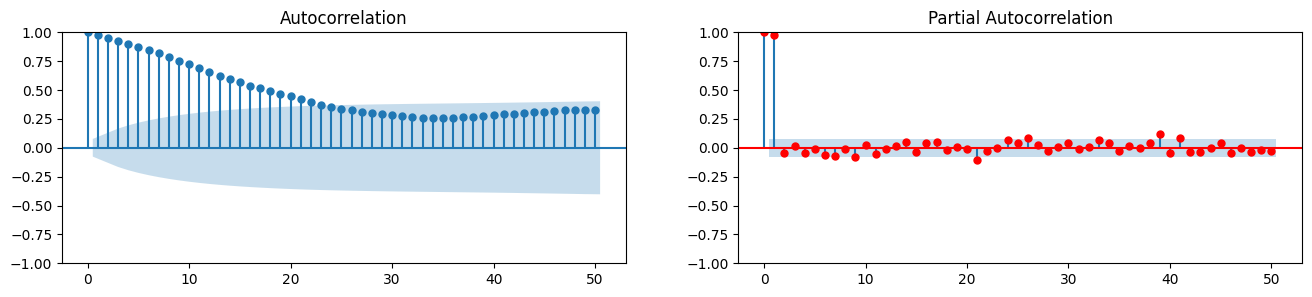

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(16,3))

plot_acf(train_df.tiktok, lags=50, ax=axes[0]);
plot_pacf(train_df.tiktok, lags=50, ax=axes[1], color='r');